In [1]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch import nn
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from torch.nn.parameter import Parameter

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import nflib_bkp as tnf

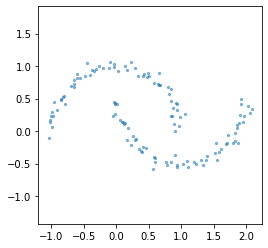

In [3]:
# Lightweight datasets
from sklearn import datasets

class DatasetMoons:
    """ two half-moons """
    def sample(self, n):
        moons = datasets.make_moons(n_samples=n, noise=0.05)[0].astype(np.float32)
        return torch.from_numpy(moons)

class DatasetMixture:
    """ 4 mixture of gaussians """
    def sample(self, n):
        assert n%4 == 0
        r = np.r_[np.random.randn(n // 4, 2)*0.5 + np.array([0, -2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([0, 0]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([2, 2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([-2, 2])]
        return torch.from_numpy(r.astype(np.float32))

d = DatasetMoons()
# d = DatasetMixture()

x = d.sample(128)
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.axis('equal');

In [4]:
prior = MultivariateNormal(torch.zeros(2), torch.eye(2))

In [5]:
# prior = distributions.TransformedDistribution(
#     distributions.Uniform(torch.zeros(2), torch.ones(2)),
#     distributions.SigmoidTransform().inv)

In [6]:
# layers = []
# for i in range(8):
#     _a = tnf.LinearFlow(2)
#     _b = tnf.PReluFLow(2)
#     layers += [_a,_b]
# layers.append(tnf.LinearFlow(2))
# layers.append(tnf.ActNorm1d(2))    

In [7]:
# layers = [
#     tnf.ResidualMLP(2, [20,20,20,20], n_iter=1000),
#     tnf.ActNorm1d(2)
# ]

In [8]:
# x = d.sample(128)
# yy, log_det = layers[0](x, True)
# log_det

In [9]:
mlpg = tnf.coupling_flows.MLP_Generator([24,24,24])
# dimx = tnf.coupling_flows.DimensionMixer(2)

layers = []
for i in range(8):
    _a = tnf.CouplingFlow(2, func_generator=mlpg, dim_sample=i%2, scale=False)
    _b = tnf.ActNorm1d(2)
    layers += [_b,_a]
layers.append(tnf.LinearFlow(2))

In [10]:
# mlpg.generate(1,1)

In [11]:
model = tnf.NormalizingFlow(layers, prior)
# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) # todo tune WD
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  10222


In [12]:
model.train()
for k in range(2000):
    x = d.sample(128)
    
    yy, log_det, prior_logprob = model(x, True, True)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob) # NLL

    model.zero_grad()
    loss.backward()
    optimizer.step()

    if k % 100 == 0:
        print(loss.item())

278.92279052734375
258.68646240234375
249.1790313720703
244.76019287109375
242.26385498046875
232.83590698242188
226.51011657714844
224.7591552734375
222.34153747558594
214.89581298828125
217.76002502441406
220.39456176757812
218.0560302734375
215.39892578125
213.46376037597656
215.31912231445312
215.2117462158203
214.417724609375
212.89111328125
211.23577880859375


Text(0.5, 1.0, 'z -> x')

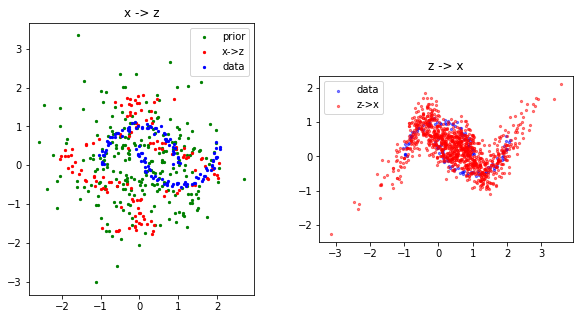

In [13]:
model.eval()

x = d.sample(128)
z, log_det, prior_logprob = model(x, True, True)

x = x.detach().numpy()
z = z.detach().numpy()
p = prior.sample([128, 2]).squeeze()
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')

z = model.sample(128*8)
z = z.detach().numpy()
plt.subplot(122)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')

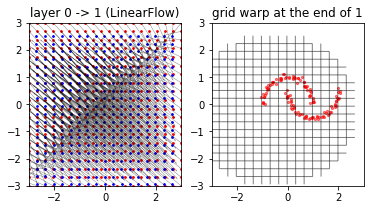

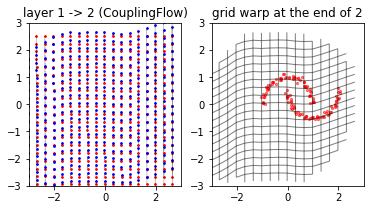

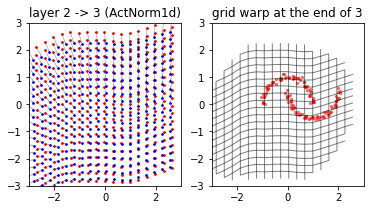

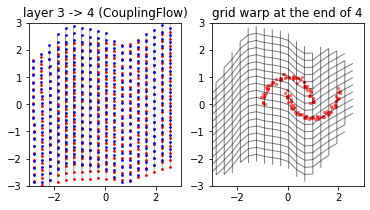

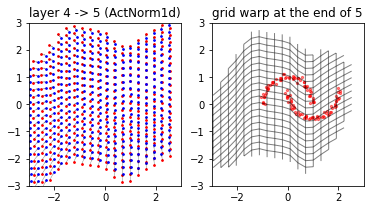

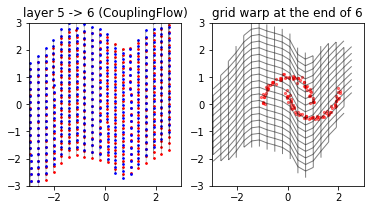

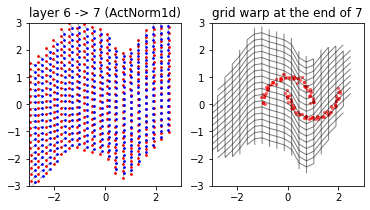

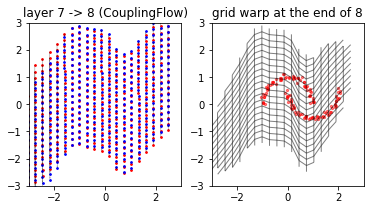

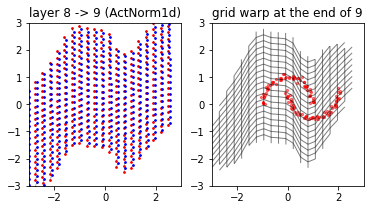

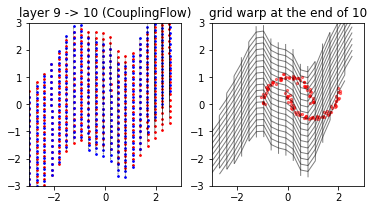

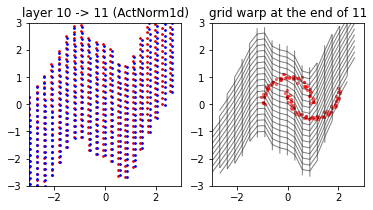

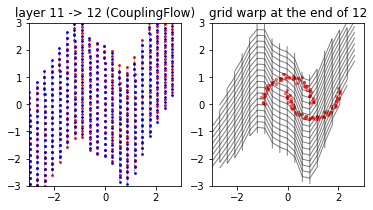

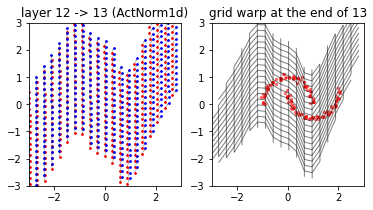

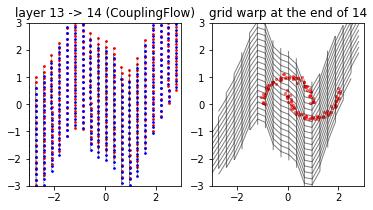

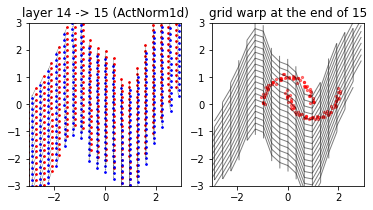

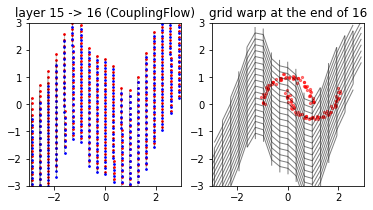

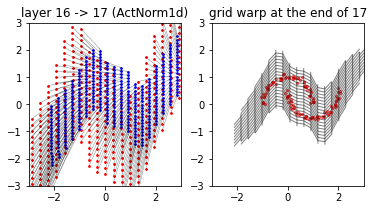

In [14]:
# Visualize the step-wise flow in the full net
from matplotlib import collections  as mc

# plot the coordinate warp
ng = 20
xx, yy = np.linspace(-3, 3, ng), np.linspace(-3, 3, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv, yv], axis=-1)
in_circle = np.sqrt((xy**2).sum(axis=2)) <= 3 # seems appropriate since we use radial distributions as priors
xy = xy.reshape((ng*ng, 2))
xy = torch.from_numpy(xy.astype(np.float32))

zs, log_det = model.inverse_intermediate(xy, True)
# zs = zs[1:]
backward_flow_names = [type(f).__name__ for f in model.flow.flow_list[::-1]]
nz = len(zs)
for i in range(nz - 1):
    z0 = zs[i].detach().numpy()
    z1 = zs[i+1].detach().numpy()
    
    # plot how the samples travel at this stage
    figs, axs = plt.subplots(1, 2, figsize=(6, 3))
    #plt.figure(figsize=(20,10))
    axs[0].scatter(z0[:,0], z0[:, 1], c='r', s=3)
    axs[0].scatter(z1[:,0], z1[:, 1], c='b', s=3)
    axs[0].quiver(z0[:,0], z0[:,1], z1[:,0] - z0[:,0], z1[:,1] - z0[:,1], units='xy', scale=1, alpha=0.5)
    axs[0].axis([-3, 3, -3, 3])
    axs[0].set_title("layer %d -> %d (%s)" % (i, i+1, backward_flow_names[i]))
    
    q = z1.reshape((ng, ng, 2))
    # y coords
    p1 = np.reshape(q[1:,:,:], (ng**2-ng,2))
    p2 = np.reshape(q[:-1,:,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[1:,:] | in_circle[:-1,:], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcy = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    # x coords
    p1 = np.reshape(q[:,1:,:], (ng**2-ng,2))
    p2 = np.reshape(q[:,:-1,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[:,1:] | in_circle[:,:-1], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcx = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    # draw the lines
    axs[1].add_collection(lcy)
    axs[1].add_collection(lcx)
    axs[1].axis([-3, 3, -3, 3])
    axs[1].set_title("grid warp at the end of %d" % (i+1,))
    
    # draw the data too
    plt.scatter(x[:,0], x[:,1], c='r', s=5, alpha=0.5)